# Data Exploration

This notebook provides exploratory data analysis for the thesis, including:
1. Analysis of data filters and their impact on sample composition
2. Descriptive statistics by default status
3. Temporal distribution of defaults and sample size

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH, ACTIVE_FEATURE_NAME_MAP
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.plotting import (
    set_thesis_style, COLORS, FIGSIZE, save_figure, despine,
)

# Output directory for figures
FIGURES_DIR = PROJ_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

# Output directory for tables
TABLES_DIR = PROJ_ROOT / "tables"
TABLES_DIR.mkdir(exist_ok=True)

# Initialize thesis-quality plotting style
set_thesis_style(use_tex=True)

print(f"Project root: {PROJ_ROOT}")

Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis


In [2]:
# Load full dataset
df_full = pd.read_parquet(FEATURE_CACHE_PATH)
print(f"Full dataset: {len(df_full):,} observations")
print(f"Date range: {df_full['ser_year'].min()} - {df_full['ser_year'].max()}")

Full dataset: 12,415,724 observations
Date range: 1998 - 2023


## 1. Filter Analysis

Analysis of data filters and their impact on sample composition, including the proportion of observations and default rates for each filter category.

In [3]:
def compute_filter_stats(df, column, value_labels=None):
    """
    Compute statistics for a filter variable.
    
    Args:
        df: DataFrame with the data
        column: Column name to analyze
        value_labels: Optional dict mapping values to labels
    
    Returns:
        DataFrame with N, % of Total, N Defaults, Default Rate for each value
    """
    # Get target variable (handle potential NaN)
    target = df['target_next_year'].fillna(0)
    
    results = []
    for value in sorted(df[column].dropna().unique()):
        mask = df[column] == value
        n = mask.sum()
        n_defaults = target[mask].sum()
        default_rate = n_defaults / n if n > 0 else 0
        
        label = value_labels.get(value, value) if value_labels else value
        results.append({
            'Value': label,
            'N': n,
            '% of Total': n / len(df) * 100,
            'N Defaults': int(n_defaults),
            'Default Rate (%)': default_rate * 100
        })
    
    return pd.DataFrame(results)

### 1.1 Active Status (ser_aktiv)

In [4]:
aktiv_labels = {0: 'Inactive (0)', 1: 'Active (1)'}
aktiv_stats = compute_filter_stats(df_full, 'ser_aktiv', aktiv_labels)

print("="*80)
print("ACTIVE STATUS (ser_aktiv)")
print("="*80)
print("Filter: ser_aktiv == 1 (Active companies only)")
print()
print(aktiv_stats.to_string(index=False))

ACTIVE STATUS (ser_aktiv)
Filter: ser_aktiv == 1 (Active companies only)

       Value       N  % of Total  N Defaults  Default Rate (%)
Inactive (0) 2523321   20.323591       75128          2.977346
  Active (1) 9892403   79.676409       71093          0.718663


### 1.2 Size Category (sme_category)

In [5]:
sme_stats = compute_filter_stats(df_full, 'sme_category')

print("="*80)
print("SIZE CATEGORY (sme_category)")
print("="*80)
print("Filter: sme_category in ['Small', 'Medium']")
print()
print(sme_stats.to_string(index=False))

SIZE CATEGORY (sme_category)
Filter: sme_category in ['Small', 'Medium']

 Value        N  % of Total  N Defaults  Default Rate (%)
 Large    40540    0.326521         116          0.286137
Medium   141884    1.142777         992          0.699163
 Micro 11441062   92.149777      135718          1.186236
 Small   792238    6.380925        9395          1.185881


### 1.3 Credit Reporting Status (knc_kncfall)

In [6]:
knc_stats = compute_filter_stats(df_full, 'knc_kncfall')

print("="*80)
print("CREDIT REPORTING STATUS (knc_kncfall)")
print("="*80)
print("Filter: knc_kncfall == 1 (Credit reporting companies)")
print()
print(knc_stats.to_string(index=False))

CREDIT REPORTING STATUS (knc_kncfall)
Filter: knc_kncfall == 1 (Credit reporting companies)

 Value       N  % of Total  N Defaults  Default Rate (%)
     1 9064718   73.009983      125661          1.386265
     2  963247    7.758283        5308          0.551053
     3 2030491   16.354189       13277          0.653881
     4  357265    2.877520        1975          0.552811


### 1.4 Industry (bransch_borsbransch_konv)

In [7]:
# Create binary indicator for financial services (40.0) vs. others
df_full['is_financial'] = (df_full['bransch_borsbransch_konv'] == '40.0').astype(int)

industry_labels = {0: 'Non-Financial', 1: 'Financial (40.0)'}
industry_stats = compute_filter_stats(df_full, 'is_financial', industry_labels)

print("="*80)
print("INDUSTRY (bransch_borsbransch_konv)")
print("="*80)
print("Filter: bransch_borsbransch_konv != '40.0' (Exclude financial services)")
print()
print(industry_stats.to_string(index=False))

# Clean up
df_full.drop(columns=['is_financial'], inplace=True)

INDUSTRY (bransch_borsbransch_konv)
Filter: bransch_borsbransch_konv != '40.0' (Exclude financial services)

           Value        N  % of Total  N Defaults  Default Rate (%)
   Non-Financial 10847679   87.370491      139398          1.285049
Financial (40.0)  1568045   12.629509        6823          0.435128


### 1.5 Combined Filter Summary

In [8]:
# Apply combined filters
df_filtered = df_full[
    (df_full["ser_aktiv"] == 1) & 
    (df_full["sme_category"].isin(["Small", "Medium"])) & 
    (df_full["knc_kncfall"] == 1) &
    (df_full["bransch_borsbransch_konv"] != "40.0")
].copy()

print("="*80)
print("COMBINED FILTER SUMMARY")
print("="*80)
print(f"\nFull dataset:     {len(df_full):>12,} observations")
print(f"Filtered dataset: {len(df_filtered):>12,} observations")
print(f"Retention rate:   {len(df_filtered)/len(df_full)*100:>12.1f}%")
print("\nFilters applied:")
print("  - Active companies (ser_aktiv == 1)")
print("  - Small & Medium SMEs")
print("  - Credit reporting companies (knc_kncfall == 1)")
print("  - Excluded industry: 40.0 (Financial services)")

COMBINED FILTER SUMMARY

Full dataset:       12,415,724 observations
Filtered dataset:      326,658 observations
Retention rate:            2.6%

Filters applied:
  - Active companies (ser_aktiv == 1)
  - Small & Medium SMEs
  - Credit reporting companies (knc_kncfall == 1)
  - Excluded industry: 40.0 (Financial services)


## 2. Descriptive Statistics by Default Status

Summary statistics (mean, variance, skewness, kurtosis) for each variable, split by defaulting and non-defaulting firms.

In [9]:
# Prepare modeling data from filtered dataset
X, y = prepare_modeling_data(df_filtered)

print(f"Modeling dataset: {len(X):,} observations")
print(f"Default rate: {y.mean()*100:.2f}%")
print(f"Non-defaults: {(y==0).sum():,}")
print(f"Defaults: {(y==1).sum():,}")

Modeling dataset: 304,149 observations
Default rate: 1.76%
Non-defaults: 298,795
Defaults: 5,354


In [10]:
def compute_descriptive_stats(X, y):
    """
    Compute mean, variance, skewness, kurtosis for each numeric feature,
    split by default status.
    
    Returns:
        DataFrame with statistics for non-defaulting and defaulting firms
    """
    # Select only numeric columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    # Split data by default status
    X_no_default = X.loc[y == 0, numeric_cols]
    X_default = X.loc[y == 1, numeric_cols]
    
    results = []
    for col in numeric_cols:
        # Non-defaulting firms
        data_nd = X_no_default[col].dropna()
        # Defaulting firms
        data_d = X_default[col].dropna()
        
        results.append({
            'Variable': col,
            # Non-defaulting
            'Mean (ND)': data_nd.mean(),
            'Std (ND)': data_nd.std(),
            'Skew (ND)': stats.skew(data_nd, nan_policy='omit') if len(data_nd) > 2 else np.nan,
            'Kurt (ND)': stats.kurtosis(data_nd, nan_policy='omit') if len(data_nd) > 3 else np.nan,
            # Defaulting
            'Mean (D)': data_d.mean(),
            'Std (D)': data_d.std(),
            'Skew (D)': stats.skew(data_d, nan_policy='omit') if len(data_d) > 2 else np.nan,
            'Kurt (D)': stats.kurtosis(data_d, nan_policy='omit') if len(data_d) > 3 else np.nan,
        })
    
    return pd.DataFrame(results)

In [11]:
desc_stats = compute_descriptive_stats(X, y)

print("="*120)
print("DESCRIPTIVE STATISTICS BY DEFAULT STATUS")
print("="*120)
print("ND = Non-Defaulting firms, D = Defaulting firms")
print()

# Format for display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if abs(x) < 1000 else f'{x:.2e}')

print(desc_stats.to_string(index=False))

# -----------------------------------------------------------------------------
# Generate LaTeX table with nice feature names and proper rounding
# -----------------------------------------------------------------------------

def format_stat(val, stat_type='mean'):
    """Format a statistic for LaTeX output with thesis-quality formatting.
    
    Args:
        val: The value to format
        stat_type: One of 'mean', 'std', 'skew', 'kurt'
    """
    if pd.isna(val):
        return "--"
    
    abs_val = abs(val)
    
    if stat_type in ['skew', 'kurt']:
        # Skewness and kurtosis: show magnitude clearly
        if abs_val >= 10000:
            # Use thousands separator: 15,900 instead of 1.59e+04
            return f"{val:,.0f}"
        elif abs_val >= 100:
            return f"{val:,.0f}"
        elif abs_val >= 10:
            return f"{val:.1f}"
        else:
            return f"{val:.2f}"
    else:
        # Mean and Std
        if abs_val >= 10000:
            return f"{val:,.0f}"
        elif abs_val >= 1000:
            return f"{val:,.0f}"
        elif abs_val >= 100:
            return f"{val:.1f}"
        elif abs_val >= 10:
            return f"{val:.2f}"
        elif abs_val >= 1:
            return f"{val:.2f}"
        elif abs_val >= 0.001:
            return f"{val:.3f}"
        else:
            return f"{val:.4f}"

# Create LaTeX-ready dataframe
latex_df = desc_stats.copy()

# Map variable names to nice names
latex_df['Variable'] = latex_df['Variable'].map(
    lambda x: ACTIVE_FEATURE_NAME_MAP.get(x, x)
)

# Format each statistic column with appropriate formatting
latex_df['Mean (ND)'] = latex_df['Mean (ND)'].apply(lambda x: format_stat(x, 'mean'))
latex_df['Std (ND)'] = latex_df['Std (ND)'].apply(lambda x: format_stat(x, 'std'))
latex_df['Skew (ND)'] = latex_df['Skew (ND)'].apply(lambda x: format_stat(x, 'skew'))
latex_df['Kurt (ND)'] = latex_df['Kurt (ND)'].apply(lambda x: format_stat(x, 'kurt'))
latex_df['Mean (D)'] = latex_df['Mean (D)'].apply(lambda x: format_stat(x, 'mean'))
latex_df['Std (D)'] = latex_df['Std (D)'].apply(lambda x: format_stat(x, 'std'))
latex_df['Skew (D)'] = latex_df['Skew (D)'].apply(lambda x: format_stat(x, 'skew'))
latex_df['Kurt (D)'] = latex_df['Kurt (D)'].apply(lambda x: format_stat(x, 'kurt'))

# Rename columns for LaTeX (short names for compactness)
latex_df.columns = [
    'Variable',
    'Mean', 'Std', 'Skew', 'Kurt',  # Non-defaulting
    'Mean', 'Std', 'Skew', 'Kurt',  # Defaulting
]

# Generate LaTeX with siunitx S columns for number alignment (optional)
# Using @{\hskip 4pt} for compact horizontal spacing
latex_table = latex_df.to_latex(
    index=False,
    escape=False,
    column_format='l@{\\hskip 4pt}r@{\\hskip 4pt}r@{\\hskip 4pt}r@{\\hskip 4pt}r@{\\hskip 8pt}r@{\\hskip 4pt}r@{\\hskip 4pt}r@{\\hskip 4pt}r',
    caption="Descriptive statistics by default status. Non-defaulting firms ($N$=298,795), Defaulting firms ($N$=5,354).",
    label="tab:descriptive_stats",
    position="htbp",
)

# Add multicolumn headers and booktabs rules
lines = latex_table.split('\n')
new_lines = []
for i, line in enumerate(lines):
    # Add toprule after begin{table}
    if '\\begin{tabular}' in line:
        new_lines.append(line)
        new_lines.append('\\toprule')
        continue
    # Add multicolumn header before the column header line
    if 'Variable & Mean & Std & Skew & Kurt & Mean & Std & Skew & Kurt' in line:
        new_lines.append(' & \\multicolumn{4}{c}{Non-Defaulting} & \\multicolumn{4}{c}{Defaulting} \\\\')
        new_lines.append('\\cmidrule(lr){2-5} \\cmidrule(lr){6-9}')
        new_lines.append(line)
        new_lines.append('\\midrule')
        continue
    # Skip the auto-generated \hline commands
    if line.strip() == '\\hline':
        continue
    # Add bottomrule before end{tabular}
    if '\\end{tabular}' in line:
        new_lines.append('\\bottomrule')
        new_lines.append(line)
        continue
    new_lines.append(line)

latex_table = '\n'.join(new_lines)

# Save to file
latex_path = TABLES_DIR / "descriptive_stats.tex"
with open(latex_path, 'w') as f:
    f.write(latex_table)

print(f"\n{'='*80}")
print("LATEX TABLE")
print("="*80)
print(latex_table)
print(f"\nLaTeX table saved to: {latex_path}")

DESCRIPTIVE STATISTICS BY DEFAULT STATUS
ND = Non-Defaulting firms, D = Defaulting firms

            Variable  Mean (ND)  Std (ND)  Skew (ND)  Kurt (ND)  Mean (D)  Std (D)  Skew (D)  Kurt (D)
         company_age    16.2766   14.1107     1.7758     5.2240   10.0035  10.4131    2.5660   10.3847
          ny_kapomsh     2.9076    5.9007   346.5960   1.59e+05    7.1783 242.6212   73.0498  5.34e+03
         ny_skuldgrd     6.7105   95.8161   104.7956   1.86e+04   21.5660 173.2174   52.8440  3.02e+03
            ny_solid     0.3551    0.2119     0.5335     1.6763    0.1629   0.1584    1.9396    4.9124
         ny_avkegkap     0.0290    9.4593   -65.9360   9.81e+03   -1.5907  11.3632   -8.7439  334.9737
         ny_kasslikv     1.9587  133.9798   502.9729   2.64e+05    0.8390   1.5092   44.8261  2.64e+03
        ny_nettomarg    -0.9283  133.9444  -303.6344   1.18e+05   -4.4987 217.5753  -60.0685  3.82e+03
             ny_omsf     4.4880  935.8516   435.5599   2.08e+05    6.1698 195.7545   5

## 3. Temporal Distribution

Default rate and number of observations for each year in the data.

In [12]:
# Add target to filtered data for temporal analysis
df_with_target = df_filtered.copy()
df_with_target = df_with_target[df_with_target['target_next_year'].notna()]

# Compute yearly statistics
yearly_stats = df_with_target.groupby('ser_year').agg(
    n_observations=('target_next_year', 'count'),
    n_defaults=('target_next_year', 'sum'),
).reset_index()

yearly_stats['default_rate'] = yearly_stats['n_defaults'] / yearly_stats['n_observations'] * 100

# Filter out years with no observations or incomplete data
yearly_stats = yearly_stats[yearly_stats['n_observations'] > 0]

print("="*80)
print("YEARLY STATISTICS")
print("="*80)
print(yearly_stats.to_string(index=False))

YEARLY STATISTICS
 ser_year  n_observations  n_defaults  default_rate
     1998           10467         191        1.8248
     1999           10974         171        1.5582
     2000           11293         269        2.3820
     2001           11450         285        2.4891
     2002           11411         277        2.4275
     2003           11086         234        2.1108
     2004           10915         165        1.5117
     2005           11021         142        1.2884
     2006           11531         136        1.1794
     2007           12374         286        2.3113
     2008           12359         298        2.4112
     2009           11841         196        1.6553
     2010           12026         199        1.6547
     2011           12179         220        1.8064
     2012           11986         226        1.8855
     2013           11801         212        1.7965
     2014           11704         158        1.3500
     2015           12003         172        1

<>:16: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_98056/285715663.py:16: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel('Default Rate (\%)', color=COLORS['logit'])


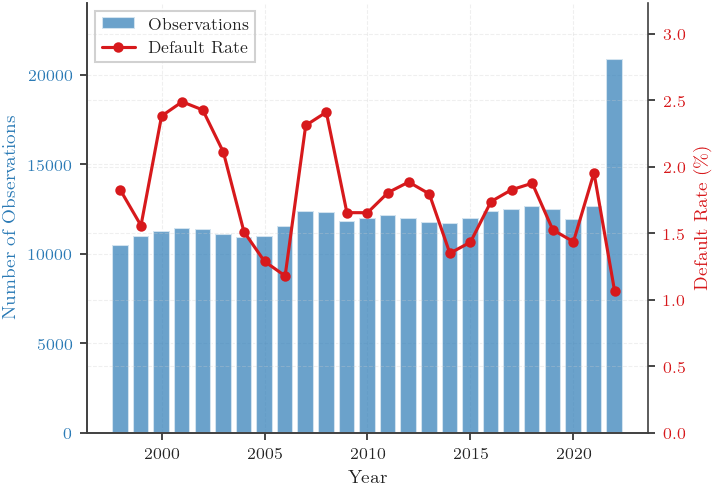


Figure saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/figures/default_rate_by_year.pdf


In [13]:
# Create dual-axis plot: observations (bar) and default rate (line)
fig, ax1 = plt.subplots(figsize=FIGSIZE['standalone'])

# Bar chart for observations
bars = ax1.bar(yearly_stats['ser_year'], yearly_stats['n_observations'], 
               color=COLORS['lgbm'], alpha=0.7, label='Observations')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Observations', color=COLORS['lgbm'])
ax1.tick_params(axis='y', labelcolor=COLORS['lgbm'])
ax1.set_ylim(0, yearly_stats['n_observations'].max() * 1.15)

# Line chart for default rate on secondary axis
ax2 = ax1.twinx()
line = ax2.plot(yearly_stats['ser_year'], yearly_stats['default_rate'], 
                color=COLORS['logit'], marker='o', linewidth=1.5, markersize=4, label='Default Rate')
ax2.set_ylabel('Default Rate (\%)', color=COLORS['logit'])
ax2.tick_params(axis='y', labelcolor=COLORS['logit'])
ax2.set_ylim(0, yearly_stats['default_rate'].max() * 1.3)
ax2.spines['right'].set_visible(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Remove only left axis top spine, keep right spine for secondary axis
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'default_rate_by_year.pdf')
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'default_rate_by_year.pdf'}")